# Technical Indicators for Bitcoin Trading

## Importing libraries and loading the data

In [1]:
import pandas as pd
import numpy as np
import quantstats as qs

from trading.technical_indicators import (
    TechnicalIndicator,
    MovingAverageCrossover,
    DualMovingAverageCrossover,
    MovingAverageConvergenceDivergence,
    RelativeStrengthIndex,
    RateOfChange
)
from trading.backtest import Backtest

Let's plot our dataset. In this first part, I split our time series into two sets: the Development set, which will be used to find the best parameters for our technical indicators (in-sample set), and the Testing set, where I will apply the best parameter combinations that I have found (out-of-sample set).

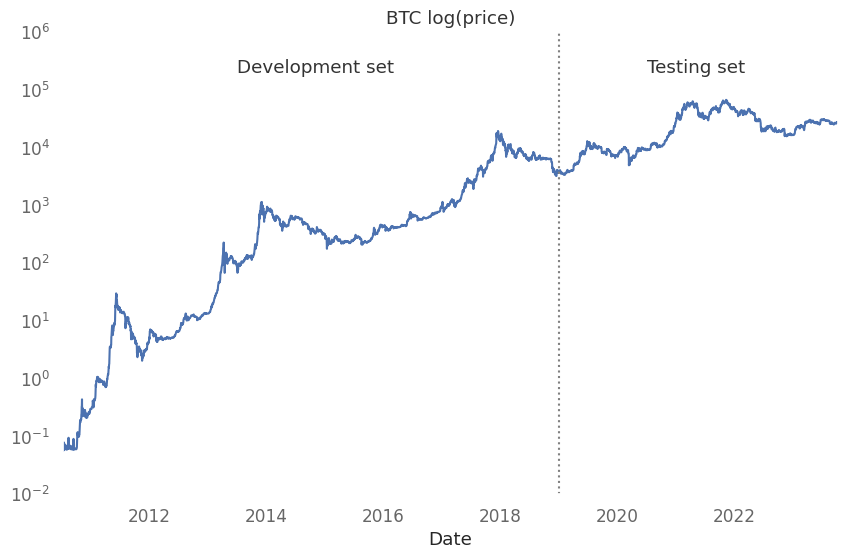

In [2]:
DATASET_FILE = 'data/CMC_BTCUSD.csv'
df = pd.read_csv(DATASET_FILE, header=0, index_col=0, parse_dates=True)
ax = df['Close'].plot(logy=True, title='BTC log(price)')
ax.axvline(pd.to_datetime('2018-12-31'), linestyle='dotted', color='gray')
ax.text(pd.to_datetime('2013-07-01'), 10 ** 5 + 100_000, 'Development set')
ax.text(pd.to_datetime('2020-07-01'), 10 ** 5 + 100_000, 'Testing set')
ax.set_ylim((10 ** -2, 10 ** 6))
ax.grid(False)

## Defining a function to search for the best Technical Indicators parameters given a dataset

The function below returns the parameter combinations that yields the best in-sample Sharpe ratio for a Technical Indicator strategy.

In [3]:
def find_best_params(
    df: pd.DataFrame,
    indicator: TechnicalIndicator,
    strategy_name: str,
    params_to_run: list[dict],
    start_date: str,
    end_date: str,
    trading_fee: float = 0.001
):
    """Finds the best in-sample parameter configuration from a given list of possible combinations.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing Open, High, Low, Close prices.
    
    indicator : trading.technical_indicators.TechnicalIndicator
        A TechnicalIndicator object.
    
    strategy_name : str
        Name of the trading strategy. This name is later used in plot legends.
    
    params_to_run : list[dict]
        List of dictionaries, where each dictionary consist of a parameter configuration to
        be tested in-sample.
    
    start_date : str
        Backtest starting date in the format YYYY-mm-dd.
    
    end_date : str
        Backtest ending date in the format YYYY-mm-dd.
    
    trading_fee : float (default: 0.001)
        Trading fee.
    """
    close_prices = df.loc[start_date:end_date, 'Close'].copy()
    results = []
    for params in params_to_run:
        indicator.set_params(**params)
        signals = indicator.signals(df)
        backtest = Backtest(
            strategy_name=strategy_name,
            price_series=close_prices,
            signals=signals.loc[start_date:end_date],
            trading_fee=trading_fee
        )
        backtest.run()
        sharpe = qs.stats.sharpe(backtest.series_.pct_change(), periods=365)
        results.append(dict(params=params, backtest=backtest, sharpe=sharpe))
    return max(results, key=lambda r : r['sharpe'])

## Moving Average Crossover (MAC)

The Simple Moving Average is probably the most known technical indicator. In the $i$-th day, it is calculated as the average close price of the past $n$ days, i.e.:

$$
\begin{align}
\text{SMA}_i(n) = \dfrac{1}{n} \sum_{j=i-n+1}^{i} C_j
\end{align}
$$

SMAs are commonly used to represent price trends and changes in the trend can be identified when the security price crosses the SMA. Therefore, we define a buy signal whenever the price series is above the SMA and a sell signal whenver the opposite movement occurs.

In the experiments below, the SMA is run considering windows of 1, 2, ..., 8 weeks (i.e., 1 week to 2 months).

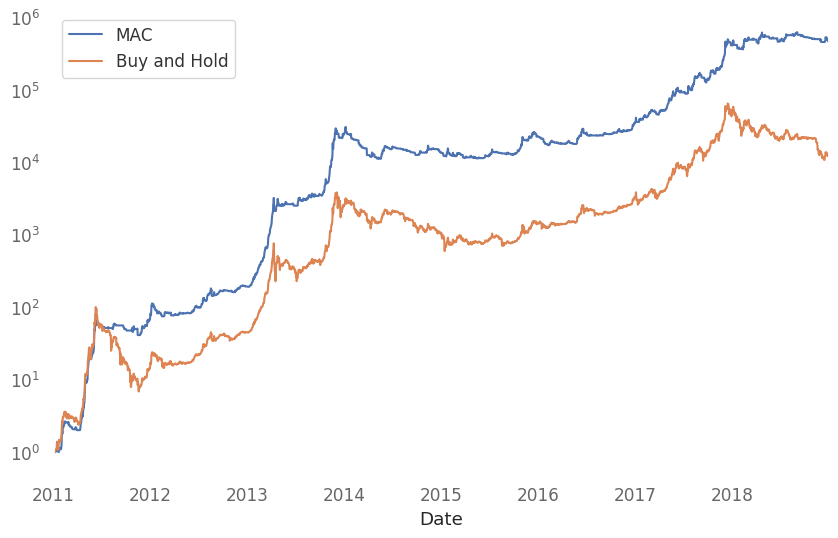

In [4]:
params_to_run = [dict(window=w) for w in range(7, 63, 7)]
mac = MovingAverageCrossover()
mac_result = find_best_params(df, mac, 'MAC', params_to_run, start_date='2011-01-01', end_date='2018-12-31')
ax = mac_result['backtest'].plot(logy=True)
ax.grid(False)

## Dual Moving Average Crossover (DMAC)

DMAC looks for buy signals defined as a shorter moving average crossing above a longer moving average. This type of approach usually reduces the influence of whipsaw movements that may occur in MAC.

In the experiment below, DMAC is run with short window lengths between 1 and 4 weeks and long window lengths between 2 weeks and 2 months.

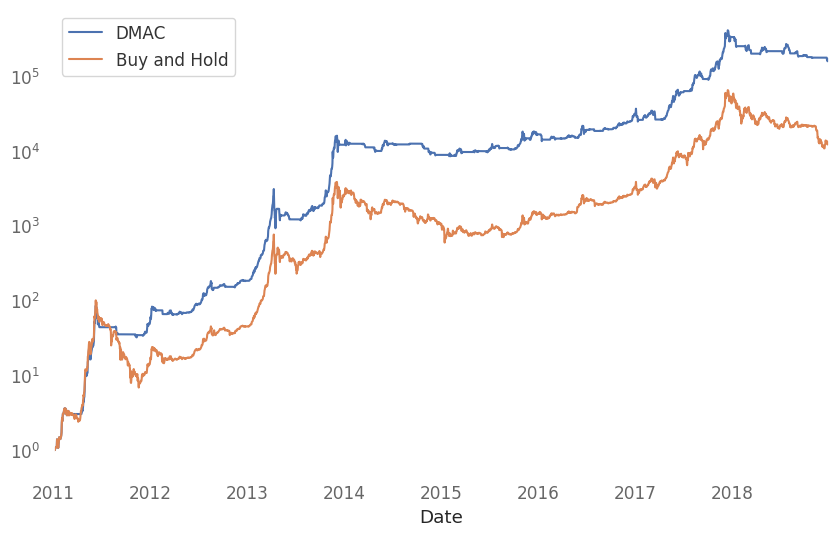

In [5]:
params_to_run = [
    dict(short_window=sw, long_window=lw)
    for sw in range(7, 35, 7)
    for lw in range(14, 63, 7) if sw < lw
]
dmac = DualMovingAverageCrossover()
dmac_result = find_best_params(df, dmac, 'DMAC', params_to_run, start_date='2011-01-01', end_date='2018-12-31')
ax = dmac_result['backtest'].plot(logy=True)
ax.grid(False)

## Moving Average Convergence Divergence (MACD)

The MACD indicator is defined as the difference between a short and a long Exponential Moving Average (EMA) of the price:

$$
\text{MACD}_i(n, m) = \text{EMA}_i(n) - \text{EMA}_i(m),
$$

where $n < m$. The rules for trading with the MACD indicator are defined with respect to the Signal line, which consists of an EMA of the MACD of the past $p$ days. Whenever the MACD is above the Signal we will enter the market, while in the opposite scenario we will be out of the market.

In this experiment, I run MACD with $n \in \{ 7, 14, 21, 28 \}$, $m \in \{ 14, 21, 28, 35, 42, 49, 56 \}$ and $p \in \{ 7, 14, 21, 28 \}$.

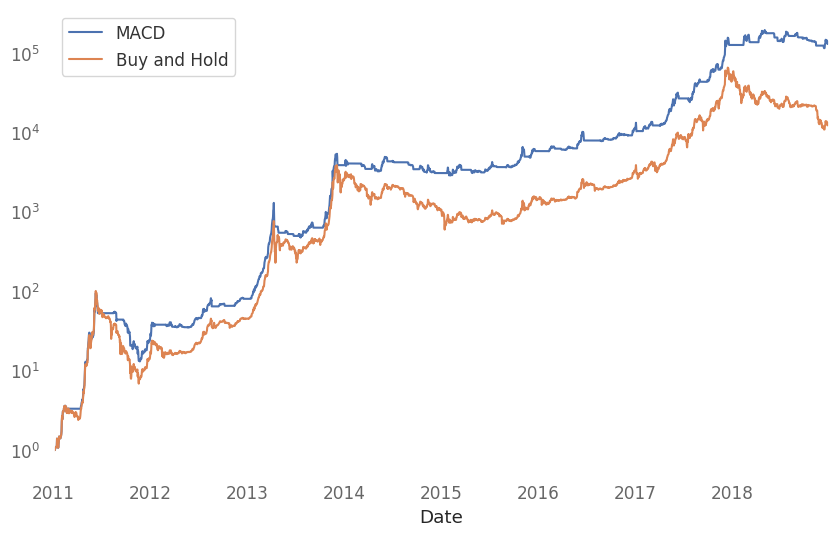

In [6]:
params_to_run = [
    dict(
        short_window=n,
        long_window=m,
        sign_window=p
    )
    for n in np.arange(7, 35, 7)
    for m in np.arange(14, 63, 7)
    for p in np.arange(7, 35, 7)
    if n < m
]
macd = MovingAverageConvergenceDivergence()
macd_result = find_best_params(df, macd, 'MACD', params_to_run, start_date='2011-01-01', end_date='2018-12-31')
ax = macd_result['backtest'].plot(logy=True)
ax.grid(False)

## Relative Strength Index (RSI)

The RSI is defined as:

$$
\text{RSI}(n) = 100 - \dfrac{100}{1+\dfrac{\text{AvgGain}}{\text{AvgLoss}}}
$$

where AvgGain and AvgLoss are calculated as the EMAs of the gains and losses in the past $n$ days, respectively. RSI varies between 0 and 100, where values close to 0 indicate oversold conditions and values close to 100 indicate overbought conditions.

RSI trading signals can be defined as: "buy", whenever RSI crosses above an oversold threshold; and "sell" (or "do nothing" if we are out of the market) whenever RSI crosses below an overbought threshold.

In this notebook, I optimize the RSI considering oversold thresholds in $\{ 20, 30, 40, 50 \}$, overbought thresholds in $\{ 50, 60, 70, 80 \}$ and a lookback window of $\{ 7, 14, 21, 28 \}$.

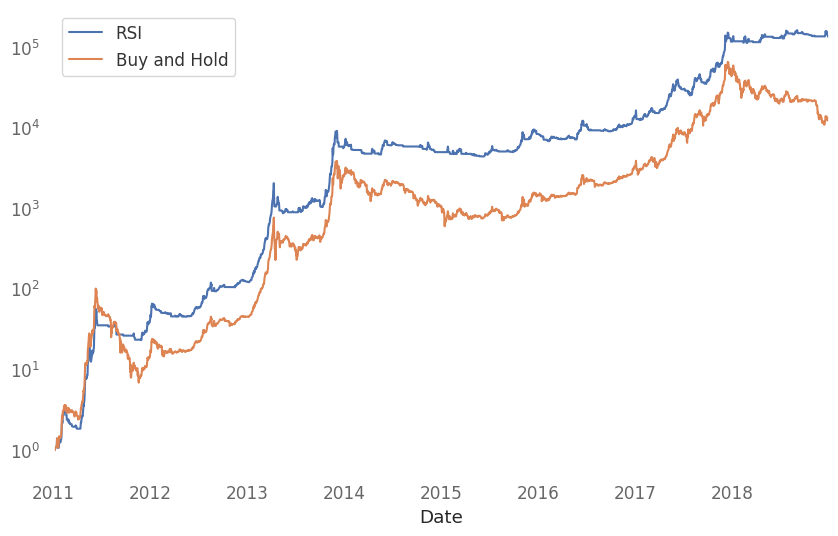

In [7]:
params_to_run = [
    dict(
        window=w,
        overbought_thr=thr1,
        oversold_thr=thr2
    )
    for w in np.arange(7, 35, 7)
    for thr1 in np.arange(50, 90, 10)
    for thr2 in np.arange(20, 60, 10)
]
rsi = RelativeStrengthIndex()
rsi_result = find_best_params(df, rsi, 'RSI', params_to_run, start_date='2011-01-01', end_date='2018-12-31')
ax = rsi_result['backtest'].plot(logy=True)
ax.grid(False)

## Rate of Change (ROC)

ROC simply measures the rate of change inside the desired window, i.e.:

$$
\text{ROC}_i(n) = \dfrac{C_i}{C_{i-n+1}} - 1
$$

where $C_i$ is the close price of the $i$-th day. The simplest trading rule is to buy the security whenever ROC is positive and sell it otherwise.

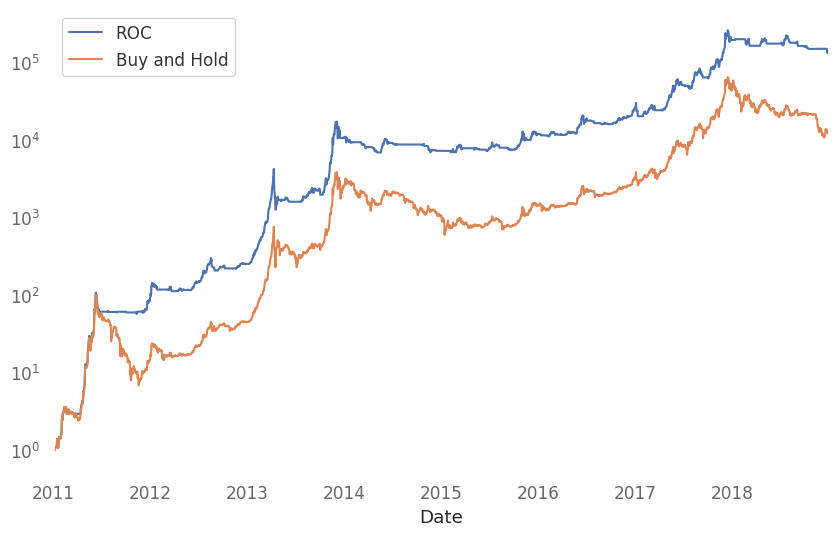

In [8]:
params_to_run = [dict(window=w, smooth=s) for w in np.arange(7, 35, 7) for s in (True, False)]
roc = RateOfChange()
roc_result = find_best_params(df, roc, 'ROC', params_to_run, start_date='2011-01-01', end_date='2018-12-31')
ax = roc_result['backtest'].plot(logy=True)
ax.grid(False)

## Comparing all Technical Indicators in-sample

Now, I compare the results of all indicators in-sample. In addition, I also consider an "Ensemble" strategy, which consists of the majority voting across the five indicators that were implemented.

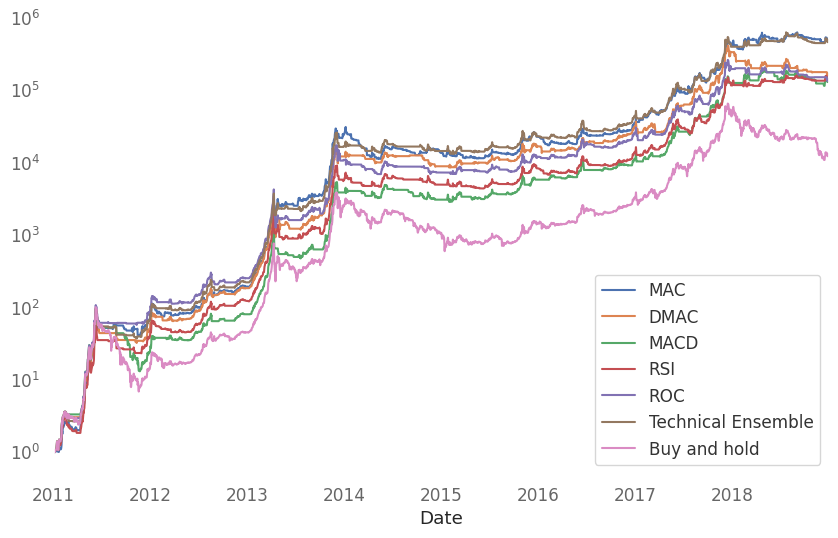

In [9]:
ensemble_signals = \
    mac_result['backtest'].signals + \
    dmac_result['backtest'].signals + \
    macd_result['backtest'].signals + \
    rsi_result['backtest'].signals + \
    roc_result['backtest'].signals

ensemble_signals = (ensemble_signals >= 3).astype(int)

ensemble_backtest = Backtest(
    strategy_name='Technical Ensemble',
    price_series=df.loc[ensemble_signals.index, 'Close'],
    signals=ensemble_signals,
    trading_fee=0.001
)
ensemble_backtest.run()

all_series_df = pd.concat([
    mac_result['backtest'].series_,
    dmac_result['backtest'].series_,
    macd_result['backtest'].series_,
    rsi_result['backtest'].series_,
    roc_result['backtest'].series_,
    ensemble_backtest.series_,
    ensemble_backtest.price_series
], axis=1)

ax = all_series_df.plot(legend=True, logy=True)
ax.grid(False)

In [10]:
sharpe = qs.stats.sharpe(all_series_df, periods=365)
sharpe.sort_values(ascending=False)

MAC                   2.622712
Technical Ensemble    2.603200
RSI                   2.389430
MACD                  2.358597
ROC                   2.342962
DMAC                  2.320493
Buy and hold          1.677939
dtype: float64

## Running MAC and the Technical Ensemble out-of-sample

According to the in-sample Sharpe Ratios and the plot of results, MAC and Technical Ensemble presented the best performances. Therefore, I chose them to run an out-of-sample test.

In [11]:
mac = MovingAverageCrossover(**mac_result['params'])
dmac = DualMovingAverageCrossover(**dmac_result['params'])
macd = MovingAverageConvergenceDivergence(**macd_result['params'])
rsi = RelativeStrengthIndex(**rsi_result['params'])
roc = RateOfChange(**roc_result['params'])

all_signals = pd.DataFrame({
    'MAC' : mac.signals(df),
    'DMAC' : dmac.signals(df),
    'MACD' : macd.signals(df),
    'RSI' : rsi.signals(df),
    'ROC' : roc.signals(df)
})
all_signals['TechnicalEnsemble'] = (all_signals.sum(axis=1) >= 3).astype(int)

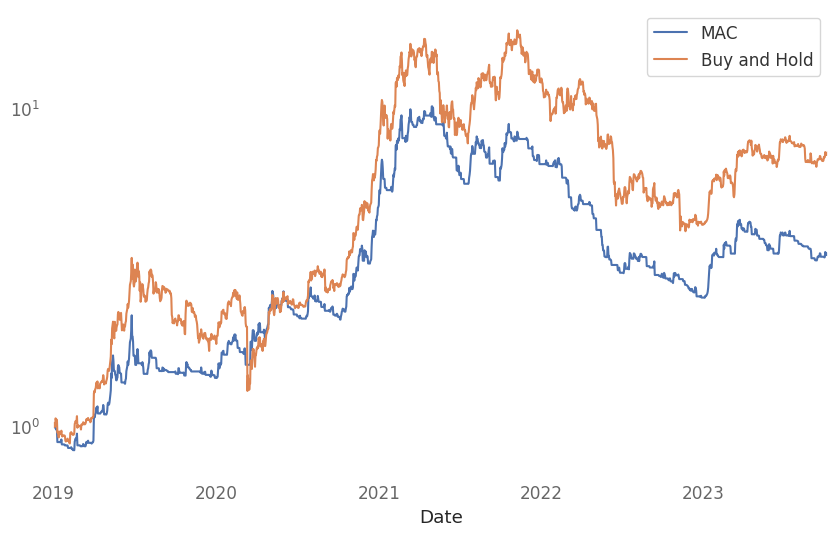

In [12]:
start_date = '2019-01-01'
mac_backtest = Backtest(
    strategy_name='MAC',
    price_series=df.loc[start_date:, 'Close'],
    signals=all_signals.loc[start_date:, 'MAC'],
    trading_fee=0.001
)
ax = mac_backtest.plot(logy=True)
ax.grid(False)

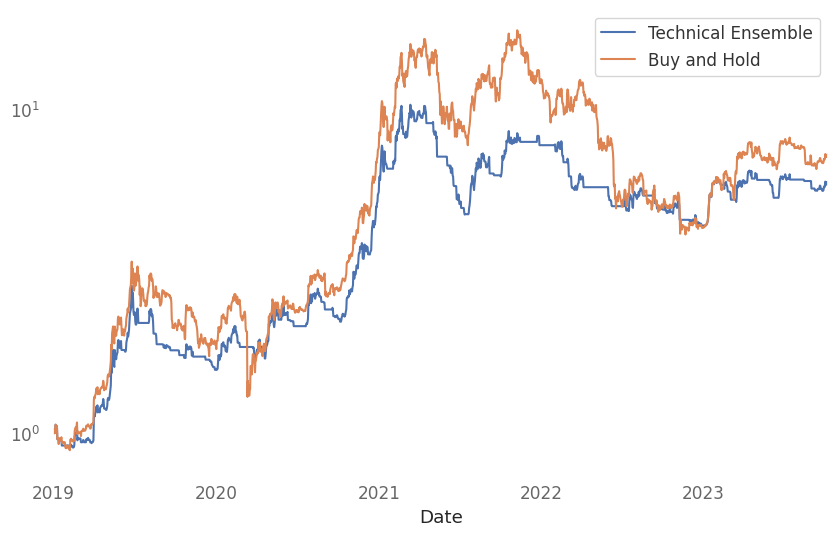

In [13]:
start_date = '2019-01-01'
ensemble_backtest = Backtest(
    strategy_name='Technical Ensemble',
    price_series=df.loc[start_date:, 'Close'],
    signals=all_signals.loc[start_date:, 'TechnicalEnsemble'],
    trading_fee=0.001
)
ax = ensemble_backtest.plot(logy=True)
ax.grid(False)

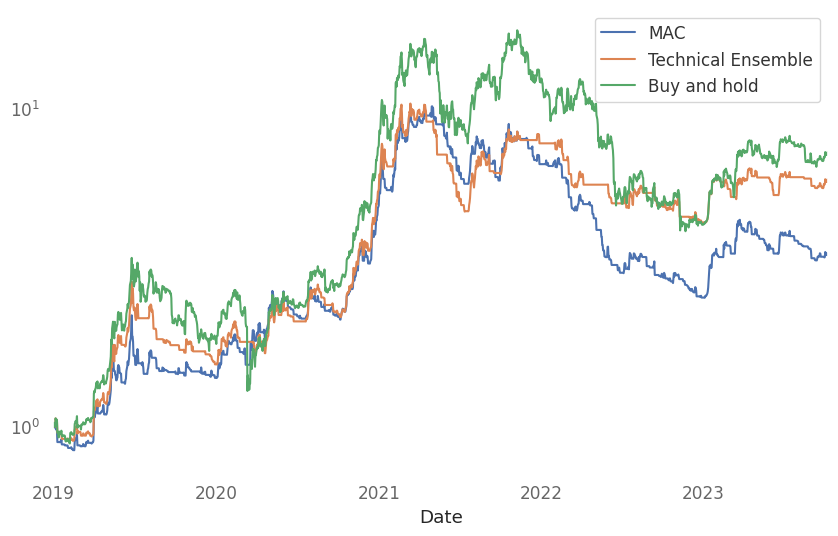

In [14]:
all_series_df = pd.concat([
    mac_backtest.series_,
    ensemble_backtest.series_,
    ensemble_backtest.price_series
], axis=1)
ax = all_series_df.plot(legend=True, logy=True)
ax.grid(False)

In [15]:
sharpe = qs.stats.sharpe(all_series_df, periods=365)
sharpe.sort_values(ascending=False)

Technical Ensemble    1.034361
Buy and hold          0.958689
MAC                   0.785113
dtype: float64

In [16]:
all_series_df.to_csv('results/test/technical_indicators.csv')

## Conclusions

When comparing in-sample and out-of-sample results, it seems that the technical indicators were overfitted in-sample, since MAC and Technical Ensemble's performances dropped significantly in the testing set. Unfortunately, it is considerably easy to overfit technical trading rules, since the signal-to-noise ratio in financial time series is generally low. Therefore, the great in-sample performance might not be replicated out-of-sample, since it may be a case of curve fitting.

In the next notebooks, I am going to investigate the application of Machine Learning methods that may help us to produce more promising and consistent results and also build models that are more robust to the presence of noise.